In [1]:
%matplotlib inline
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from math import sqrt
import pandas as pd
import numpy as np
import os, random, sys

# join result path
JoinResPath = "./data/JoinResults/"
# list of join result file names
Ilist = [i for i in os.listdir(JoinResPath) if not i.startswith(".")]

# read join result, if id is not given, randomly read one, 
# least only works when id is not given, i.e., if returned join result
# does not contain enough points, it will recusively call itself again
def readJR(Id):
    Iid = (str(Id) if type(Id)==int else Id) if Id else random.choice(Ilist)
    with open(JoinResPath+Iid,"rb") as f:
        res = []
        for i in f:
            res.append(i.strip().split(","))
    df = pd.DataFrame(res[1:])
    df[1],df[2],df[3] = pd.to_datetime(df[1]), df[2].astype(float), df[3].astype(float) 
    return (int(res[0][0]),float(res[0][1]),float(res[0][2])),df.sort([0,1])# sort_value doesn't work on server's version

# plot scatter of join result
# c is center of intersection, which will be ploted in red dot
# df is the trajectory points in the form of pandas dataframe
# kargs is the key parameters, that will be passed to the plt.scatter func
# inorder to customize the scatter plot params in global scope
def plotJR(c,df,**kargs):
    plt.scatter(df[2],df[3],**kargs)
    plt.scatter(float(c[1]),float(c[2]),color="r",s=30)
    xl,xu,yl,yu=df[2].min(),df[2].max(),df[3].min(),df[3].max()
    xrng,yrng = xu-xl or 0.001,yu-yl or 0.001
    plt.xlim([xl-.1*xrng,xu+.1*xrng])
    plt.ylim([yl-.1*yrng,yu+.1*yrng])
    plt.title("Intersection:%d, # of points:%d"%(c[0],len(df)))

# given a trajectories data frame, split it according to the time interval.
# the rng is the params passed to the dateOffset, which will define the interval.
# if two adjacent trajectory points' time intervel is grearter than this DateOffset,
# it will be divided into to two trajectories
# return result will be a list of dataframe, ordered by their first point's timestamp
def spliTraj(df,**rng):
    curr, last = None, None
    currID, lastID = None, None
    split=[0]
    for i in xrange(df.shape[0]):
        if type(curr)!=type(None):
            last, lastID = curr,currID
        curr,currID = df.iloc[i,1],df.iloc[i,0]
        if type(last)!=type(None):
            if curr>pd.DateOffset(**rng)+last or currID!=lastID:
                split.append(i)
    split.append(i+1)
    #return split
    ret = []
    for i in xrange(1,len(split)):
        splited=df.iloc[split[i-1]:split[i],:]
        ret.append(splited)
    return sorted(ret,cmp=lambda x,y:cmp(x.iloc[0,1],y.iloc[0,1]))
    
# Just like plotJR, but it will plot in the form of line.
# this func takes the results from spliTraj, so dfs is the list of dataframe
# c is still the center of the intersection, and kargs is for customizing the plot
# params in global scope
def plotJR_line(c,dfs,**kargs):
    plt.scatter(c[1],c[2],color="r",s=30)
    if type(dfs)!=list:dfs=[dfs]
    for df in dfs: 
        for t in set(df.iloc[:,0]):    
            if len(df)>1:plt.plot(df.iloc[:,2],df.iloc[:,3],**kargs)
    dfs=pd.concat(dfs)
    xl,xu,yl,yu=dfs[2].min(),dfs[2].max(),dfs[3].min(),dfs[3].max() 
    xrng,yrng = xu-xl or 0.001,yu-yl or 0.001
    plt.xlim([xl-.1*xrng,xu+.1*xrng])
    plt.ylim([yl-.1*yrng,yu+.1*yrng])
    plt.title("Intersection:%d, # of points:%d"%(c[0],len(dfs)))

# given a range and start time, filter the df (range qurey).
# no rng return df itself, 
# df could be a list of df, that actually return from splitTraj,
# or it is just a df, not list. No matter what, func will just
# filter the row of the dataframe by time range query mask
def timeRange(df,time,**rng):
    if len(rng)==0:return df
    if type(df)!=list: 
        mask = df.ix[:,1]<time+pd.DateOffset(**rng)
        mask &= df.ix[:,1]>=time
        return None if df.ix[mask,:].empty else df.ix[mask,:]
    else:
        ret = []
        for i in df:
            tmp=timeRange(i,time,**rng)
            if type(tmp)!=type(None):ret.append(tmp)
        return ret

# given the result from splitTraj, extract the info of intervals, like speed,
# directions, the direction will be normalized into unit vector
# the interval info will be called features, to contribute the inferring 
# verbose tells the progress, but makes cell messy
def calc_features(dfs,verbose=0,c=None):
    features=[]
    count=0
    for df in dfs:
        if len(df)<2:continue
        # interval infos.
        tdiff,xdiff,ydiff = [df[i].diff().iloc[1:] for i in (1,2,3)]
        # distances
        d = list(np.sqrt(xdiff**2+ydiff**2))
        # direction vectors
        xd = [0 if np.isnan(i) else i for i in (np.divide(xdiff,d))]
        yd = [0 if np.isnan(i) else i for i in (np.divide(ydiff,d))]
        # speed
        v = list(d/tdiff.astype('timedelta64[s]'))
        stacked = [v,xd,yd]
        # distances from intersections
        if c:
            x_from_center, y_from_center = np.array(df[2]-c[1]), np.array(df[3]-c[2])
            dist_sq_from_center = x_from_center**2+y_from_center**2
            stacked.append(dist_sq_from_center[1:]+dist_sq_from_center[:-1])
        features.append({"time":list(df[1]),"status":np.vstack(stacked).T})
        if verbose:
            count+=1
            print "\r%d/%d" % (count,len(dfs))
    return features

import time
class Timer():
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print "elasped time:%.1f"%self.interval

In [2]:
import pickle
# def some func to save results
def dump(obj,path):
    with open(path,"wb") as f:
        pickle.dump(obj,f,protocol=pickle.HIGHEST_PROTOCOL)
def load(path):
    with open(path,"rb") as f:
        return pickle.load(f)

In [3]:
SPLIT_INTERVAL = {"minutes":0,"hours":0,"seconds":30}
TIME_RNG = {"hours":24}
#??????????????
DIRECTION_NUM=4# ? how to select it automatically
#??????????????
COS_POW = 2 # set 0 to turn off direction, higher more weighted by one direction
DIST_VAR = 1e-3 # set 1 to make it nearly no difference, less means more weighted by distance
transform_factor = 10

def execute(_id):
    def monitoring(monitor,feature,direction): 
        starts = [(i-pd.Timestamp("00:00:00")).seconds for i in feature["time"]]
        y = feature["status"][:,0]/np.exp(feature["status"][:,3]/DIST_VAR)
        if type(direction) != type(None):
            cosine = np.dot(feature["status"][:,1:3],direction)/sqrt(2)
            similarity = map(lambda x:max([0,x]),cosine**COS_POW)
            y = y*similarity
        for i in xrange(len(y)):
            for j in xrange(starts[i],starts[i+1]):
                monitor[j].append(y[i])

    def wrapped(x):
        if len(x)==0:return 0
        return np.nanmean([i for i in x if np.isfinite(i)])
    # reading
    center,points = readJR(_id)
    print "number of points:",len(points),"...",
    if len(points)<1000:return None
    # spliting
    splitTJ = spliTraj(points,**SPLIT_INTERVAL)
    # filtering
    rngres = timeRange(splitTJ,pd.Timestamp("00:00:00"),**TIME_RNG)
    # calculating interval attrs
    features=calc_features(rngres,c=center)
    # directions
    cuml_dirs = []
    for i in features:
        filter_ = i["status"][:,1:3].sum(axis=1)!=0.0
        ##remove 1,0
        filter_ &= abs(i["status"][:,1:3].sum(axis=1))!=1
        cuml_dirs.append(i["status"][filter_,1:3])
    cuml_dirs = np.vstack(cuml_dirs)
    model = KMeans(n_clusters=DIRECTION_NUM)
    model.fit(cuml_dirs)
    directions = model.cluster_centers_   
    labels = model.labels_
    # monitoring
    speed_monitors=[]            
    for direction in directions:
        speed_monitor=[[] for i in xrange(86400)]
        for feature in features:
            monitoring(speed_monitor,feature,direction)
        speed_monitors.append(speed_monitor)
    # trends   
    trends=[]
    for i in xrange(len(directions)):
        trend = []
        for j in speed_monitors[i]:
            trend.append(wrapped(j))
        trends.append(1-1/(1+transform_factor*len(points)*np.array(trend)))
#---collecting result---#
    collector={}
    collector["len"]=len(points)
    collector["dirs"]=directions
    collector["features"]=features
    collector["trends"]=trends
    collector["coef"]=np.corrcoef(trends)
#-----------------------# 
    return collector

In [ ]:
Monitoring_PATH = "./data/MoniteringResults/"
for _id in sorted(Ilist)[15:]:
    with Timer():
        print "Executing intersection #",_id,"...",
        res = execute(_id)
        if not res: 
            print "Number is smaller than 1000, jumped.",
            continue
        dump(res,Monitoring_PATH+str(_id))
        print "done.",
print "All set!"

Executing intersection # 1011 ... number of points: 196 ... Number is smaller than 1000, jumped. elasped time:0.0
Executing intersection # 1012 ... number of points: 15956 ... done. elasped time:44.9
Executing intersection # 1013 ... number of points: 86203 ... done. elasped time:255.1
Executing intersection # 1014 ... number of points: 41811 ...

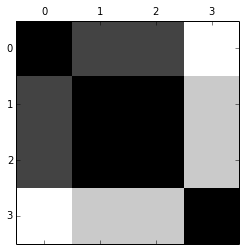

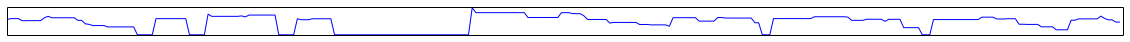

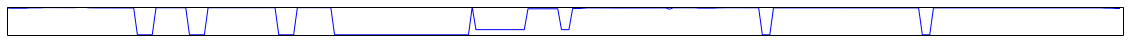

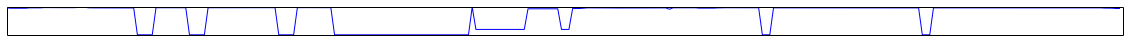

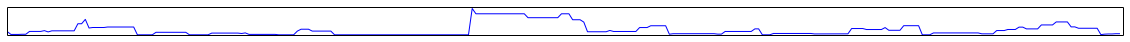

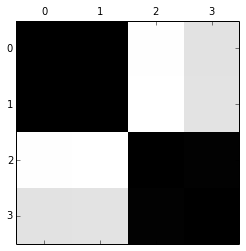

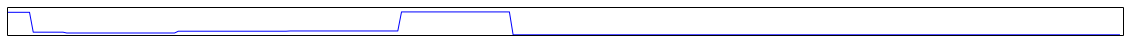

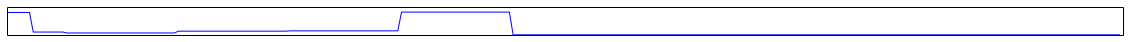

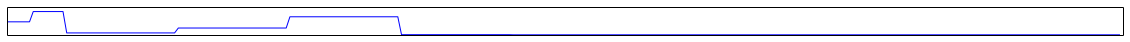

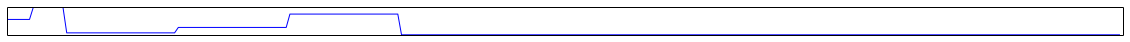

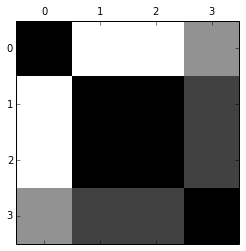

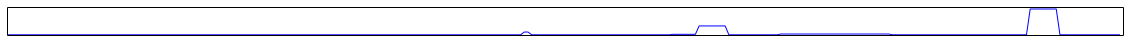

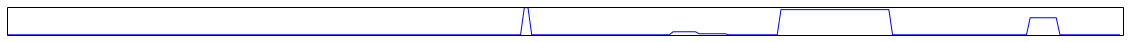

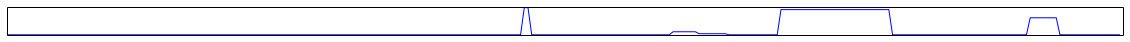

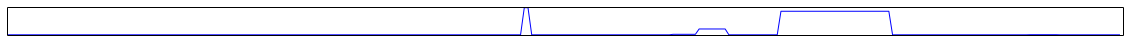

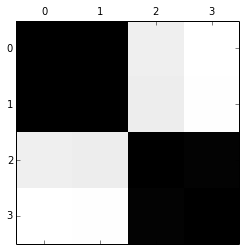

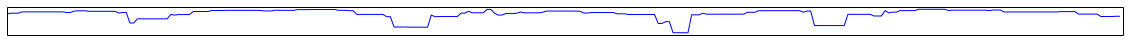

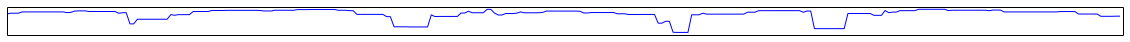

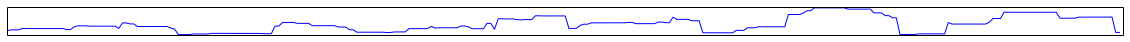

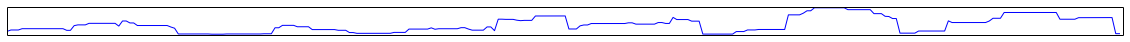

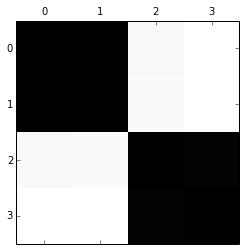

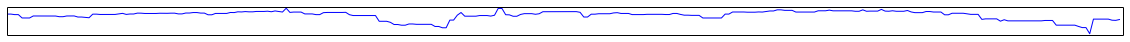

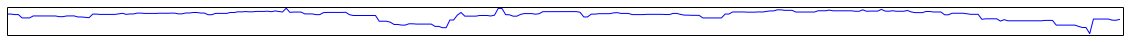

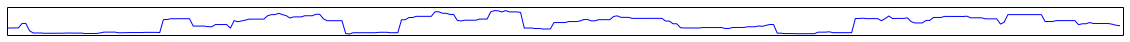

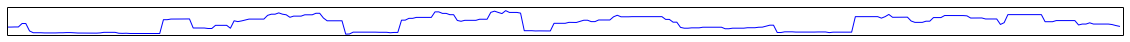

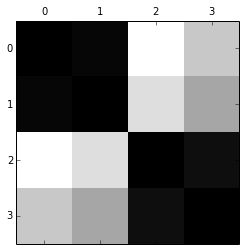

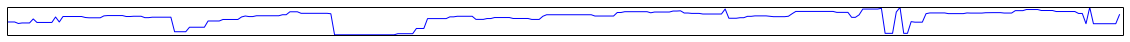

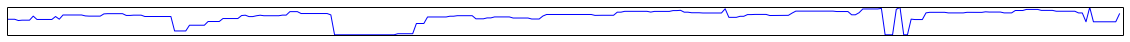

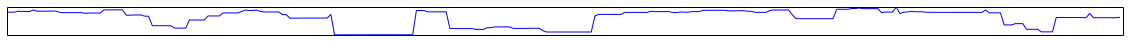

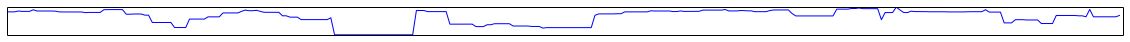

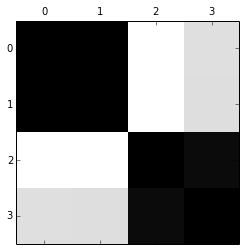

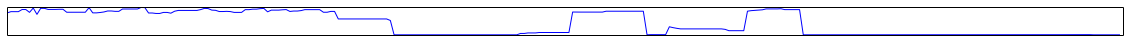

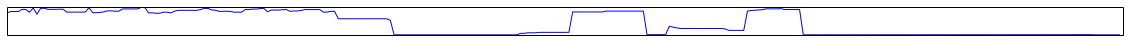

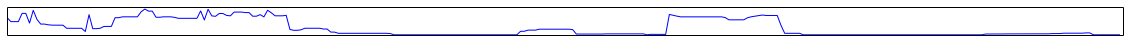

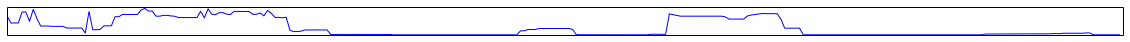

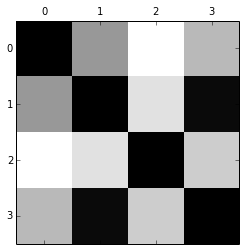

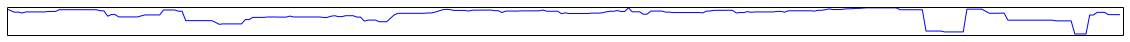

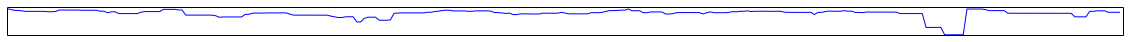

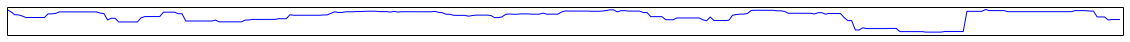

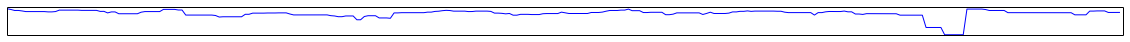

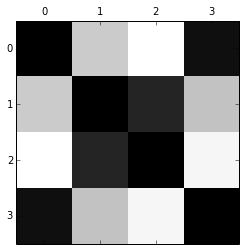

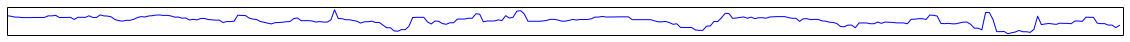

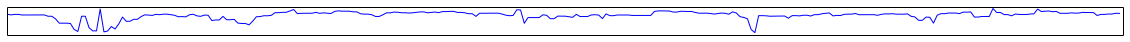

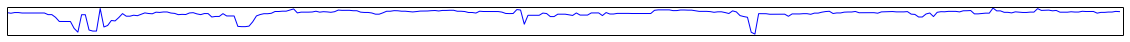

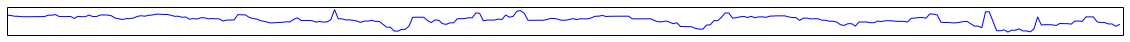

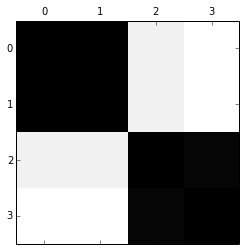

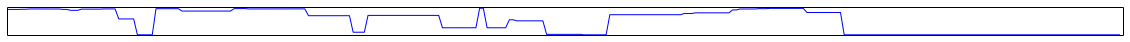

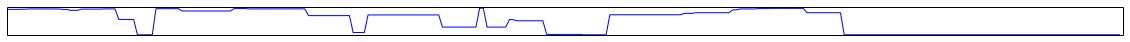

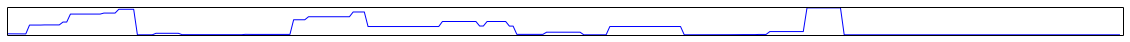

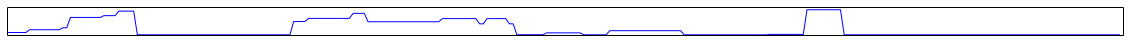

All set!


In [7]:
for _id in sorted(os.listdir(Monitoring_PATH))[:10]:
    res=load(Monitoring_PATH+str(_id))
    plt.matshow(1-res["coef"],cmap=plt.cm.gray)
    plt.show()
    for trend in res["trends"]:
        plt.figure(figsize=(20,.5))
        plt.plot(trend[40000:40300])
        plt.xticks([])
        plt.yticks([])
        plt.show()
print "All set!"